In [ ]:
#Imported Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

#Example IMDB Text Classification using TensorFlow
#https://www.tensorflow.org/hub/tutorials/tf2_text_classification
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import *

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is NOT AVAILABLE


# Detecting Fake News With Machine Learning


Import the data from the .csv files into pandas dataframes


In [ ]:
#https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
dfTrue = pd.read_csv('True.csv')
dfFake = pd.read_csv('Fake.csv')

#dfFake.columns.str.match("Unnamed")
dfFake = dfFake.loc[:,~dfFake.columns.str.match("Unnamed")]

We will trim the data down to data during the years of 2016 and 2017 as this is the point where the both datasets have similar amounts of data. At the moment Due to differing date labeling the false dataset is untrimmed. They will then be trimmed down to random samples of 1000 articles

---



In [ ]:
dfTrue['date'] = pd.to_datetime(dfTrue['date'])
dfTrue = dfTrue.loc[(dfTrue['date'] >= '2016-01-01') & (dfTrue['date'] < '2017-12-30')]
dfTrue = dfTrue.sample(n=100)

#print(dfFake)
dfFake['date'].head(10)
dfFake['date'] = pd.to_datetime(dfFake['date'])
#dfFake['year'] = dfFake['date'].year
dfFake['year'], dfFake['month'] = dfFake['date'].dt.year, dfFake['date'].dt.month

dfFake = dfFake.loc[(dfFake['year'] >= 2016) & (dfFake['year'] <= 2017)]

dfFake = dfFake.sample(n=100)

#dfTrue.duplicated().sum()
#dfFalse.duplicated().sum()
#print(dfTrue)
#dfFake.describe()

Preprocessing/Cleaning Data

In [ ]:
# Dropping the duplicated in the fake news dataset
dfFake.drop_duplicates(inplace=True)

# Dropping the duplicated in the true news dataset
dfTrue.drop_duplicates(inplace=True)

# New column in both DataFrames that identifies true/false news articles for when the data is combined
# 0 - fake news
# 1 - true news
dfFake['real'] = 0
dfTrue['real'] = 1

dfNews = pd.concat([dfFake,dfTrue],axis=0,ignore_index=True)
dfNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    200 non-null    object        
 1   text     200 non-null    object        
 2   subject  200 non-null    object        
 3   date     200 non-null    datetime64[ns]
 4   year     100 non-null    float64       
 5   month    100 non-null    float64       
 6   real     200 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 11.1+ KB


In [ ]:
import re

#Removing all punctuations
dfNews['text'] = dfNews['text'].map(lambda x: re.sub('[-,\.!?]', '', x))

#Remove @ and # symbols that is present before text
dfNews['text'] = dfNews['text'].map(lambda x: re.sub('@[A-Za-z0-9]+', '', x))
dfNews['text'] = dfNews['text'].map(lambda x: re.sub('#[A-Za-z0-9]+', '', x))

#Remove Hyperlinks 
# dfNews['text'] = dfNews['text'].map(lambda x: re.sub('https?:\/\/S++', '', x))

#Converting the text data to lower case
dfNews['text'] = dfNews['text'].map(lambda x: x.lower())

dfNews['text'].head()


0    donald trump has been a thorn in senator bob c...
1    chuck schumer s crying over muslim refugeesaft...
2    in september 2015 the sterling heights mi city...
3    a large group of very diverse young adults who...
4                                                     
Name: text, dtype: object

 Word Cloud

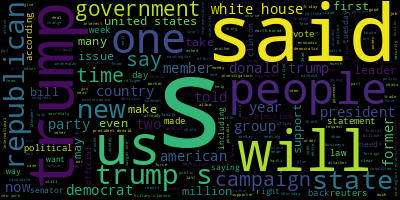

In [ ]:
#Word Cloud Visualizations
from wordcloud import WordCloud
wcFake = ' '.join(dfFake['text'])
wcTrue = ' '.join(dfTrue['text'])
wcBoth = ' '.join(dfNews['text'])
wordcloud = WordCloud()

#Most Common Words in True Articles
#wordcloud.generate(wcTrue)
#wordcloud.to_image()

#Most Common Words in Fake Articles
#wordcloud.generate(wcFalse)
#wordcloud.to_image()

#Most Common Words in True & Fake Articles
wordcloud.generate(wcBoth)
wordcloud.to_image()

Parsing the contents of each article with Spacy, lemmatizing for grouping different inflections of words, and removing stopwords. 

In [ ]:
import spacy

#Using English language model in Spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    #Parsing text (may be a lengthy process depending on how much 'text' data is used)
    doc = nlp(text)
    
    #Lemmatizing tokens and removing stop words
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    
    #Outputting what words are determined as Stopwords by Spacy
    #for word in doc:
        #print(f' {word} | {word.is_stop}')

    #Joining the lemmas back into a string
    return " ".join(lemmas)

# applying the preprocess_text function to the text column
dfNews['text'] = dfNews['text'].apply(preprocess_text)

Splitting the data into test and training sets

In [ ]:
# Loading splitting library
from sklearn.model_selection import train_test_split

X = dfNews['text'] #input of word strings
y = dfNews['real'] #0 for False and 1 for True

# Splitting the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)
#dfNews.info()

Building the model - This needs to be fine tuned, currently code is just taken from IMDB example for setup

In [ ]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train[:3])

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


Training the model

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_train, y_train),
                    verbose=1)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.8705 - accuracy: 0.4875 - val_loss: 0.8285 - val_accuracy: 0.4875
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.8285 - accuracy: 0.4875 - val_loss: 0.7899 - val_accuracy: 0.4875
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.7899 - accuracy: 0.4875 - val_loss: 0.7554 - val_accuracy: 0.4875
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.7554 - accuracy: 0.4875 - val_loss: 0.7245 - val_accuracy: 0.4875
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.7245 - accuracy: 0.4875 - val_loss: 0.6963 - val_accuracy: 0.4875
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.6963 - accuracy: 0.4875 - val_loss: 0.6705 - val_accuracy: 0.4938
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 0.6705 - accuracy: 0.4938 - val_loss: 0.6470 - val_accuracy: 0.5063
Epoch 8/20
1/1 [=========================

Evaluating the model

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

2/2 [==============================] - 0s 176ms/step - loss: 0.5823 - accuracy: 0.7000
[0.5823426842689514, 0.699999988079071]


In [ ]:
y_pred = model.predict(X_test)
#y_pred
history_dict = history.history
history_dict.keys()

2/2 [==============================] - 0s 165ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Visual Analysis of Model

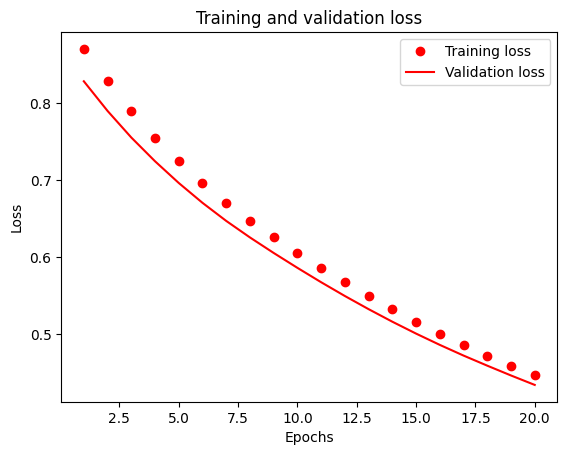

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#ConfusionMatrixDisplay(confusion_matrix=cm).plot();

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'ro', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

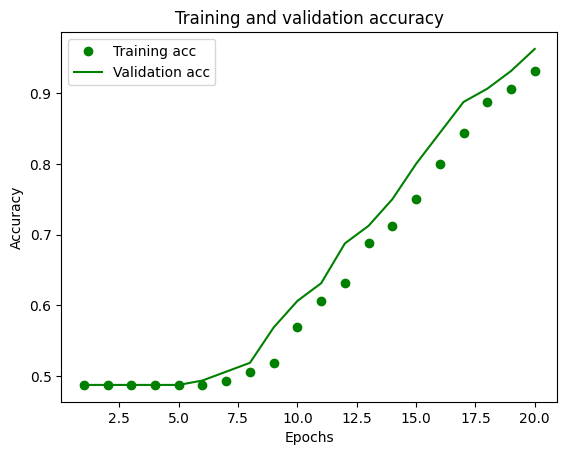

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

from sklearn.metrics import mean_squared_error
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))

print("Sqrt RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Log RMSE:",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2:",r2)

n=200 #200 inputs
k=2 #2 independent variables
adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
print("Adjusted R2 Score:",adj_r2_score)

Mean Absolute Error: 0.9440347140654921
Mean Squared Error: 1.116615829385929
Sqrt RMSE: 1.0567004444902675
Log RMSE: 0.05515126510474013
R2: -3.477657461196708
Adjusted R2 Score: -3.5231159125794163
